In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import pandas as pd
import os
import sys
sys.path.insert(0, '/home/edlitzy/PycharmProjects/UKBB/Article_files/')
sys.path.insert(0, "/home/edlitzy/PycharmProjects/UKBB/")
from UKBB_article_plots_config import *
from UKBB_article_plots_functions import *
from UKBB_Scoreboard_functions import *
# from tqdm import tqdm
import matplotlib as mpl

finished CI calculation


In [2]:
def load_labels(Score_board,y_file_name,curr_folder,mode="explore",return_results=True):
    scores=Score_board.calc_scores(mode=mode,return_results=return_results)
    df=pd.read_csv(os.path.join(curr_folder,y_file_name),index_col=0,header=None)
    scores.name="y_pred"
    df.columns=["y_test"]
    df.index.name="eid"
    df=df.join(scores,how="left")
    pred_col="y_pred"
    df = df.sort_values(pred_col, ascending=False)
    return scores,df

In [3]:
def calc_ci(rank1K):
    q25=rank1K[["Ratio","Boundaries"]].groupby("Boundaries").quantile(0.025)
    q975=rank1K[["Ratio","Boundaries"]].groupby("Boundaries").quantile(0.975)
    qmean=rank1K[["Ratio","Boundaries"]].groupby("Boundaries").mean()
    stats_df=pd.concat([qmean,q25,q975],axis=1)
    stats_df.columns=["mean","0.0275","0.975"]
    stats_df = stats_df.applymap(lambda x: '{0:.3f}'.format(x) if x<0.01 else '{0:.2f}'.format(x))
    stats_df["CI"]=stats_df["mean"]+" ["+stats_df["0.0275"]+"-"+stats_df["0.975"]+"]"
    stats_df.reset_index(inplace=True)
    stats_df["Legend"]=stats_df["Boundaries"]+" "+stats_df["CI"]
    return stats_df

# Explore folders

In [4]:
base_path="/net/mraid08/export/jafar/Yochai/UKBB_Runs/For_article/Imputed_screened/Scoreboards/"
folders=[x for x in os.listdir(base_path) if os.path.isdir(os.path.join(base_path,x))]
folders

['bu',
 'LR_Anthro_scoreboard',
 'Scoreboards_Baseline_compare',
 'LR_Five_blood_tests_scoreboard']

# Test for Five_blood_tests

## Recover relevant scoreboard

In [5]:
curr_folder=os.path.join(base_path, 'LR_Five_blood_tests_scoreboard')
scoreboard_type="Five_blood"
sb=recover_scoreboard(scoreboard_type)

('Factor:', 14.43, 'Offset:', 43.56)
('Running in ', 'None', ' mode')
('Running in ', 'None', ' mode')
('Loading ScoreBoard', 'Five_blood', ' from ', '/net/mraid08/export/jafar/Yochai/UKBB_Runs/For_article/Imputed_screened/Scoreboards/LR_Five_blood_tests_scoreboard')


## Load Scores and labels

In [6]:
val_df,val_scores=load_labels(sb,y_file_name="y_LR_val.csv",curr_folder=curr_folder,mode="explore",return_results=True)
test_df,test_scores=load_labels(sb,y_file_name="y_LR_test.csv",curr_folder=curr_folder,mode=None,return_results=True)

## Investigate validation df bins

In [7]:
val_scores.head()

,y_test,y_pred
eid,,
1098030,0.0,156.0
1585622,1.0,156.0
2512480,1.0,155.0
5695032,0.0,155.0
5823450,1.0,155.0


In [17]:
n_bins=100
res=1./n_bins
quants_bins=[0.9,0.95,0.995,1]
val_Rank_df=pd.DataFrame()
val_Rank_df=calc_Rank_df(val_scores, quants_bins=quants_bins, prevalence_thresh_fold=None,pred_col="y_pred")
val_Rank_df

,quantile number,Lower Boundary,upper Boundary,Diagnosed,All,Ratio,Fold
0,1,0.0,114.0,94.0,9704.0,0.009687,1.000000
1,2,114.0,125.0,32.0,543.0,0.058932,6.083774
2,3,125.0,145.0,96.0,462.0,0.207792,21.451230
3,4,145.0,156.0,17.0,48.0,0.354167,36.562057


In [19]:
boundaries=[0]
boundaries.extend(val_Rank_df.loc[:,["upper Boundary"]].values.flatten().tolist())
val_rank_list=[]
for ind in np.arange(1000):
    sampled_val_scores=val_scores.sample(n=val_scores.shape[0],replace=True)
    val_rank_list.append(test_rank_df(sampled_val_scores, boundaries=boundaries,pred_col="y_pred"))
val_rank1K=pd.concat(val_rank_list)
val_rank1K["Boundaries"]=(val_rank1K["Lower Boundary"]+1).astype(int).astype(str)+"-"+val_rank1K["upper Boundary"].astype(int).astype(str)
val_rank1K.to_csv(os.path.join(curr_folder,base_path,"val_scoreborad_groups_bootstrapping_results.csv"))
new_stats_df=calc_ci(val_rank1K)
new_stats_df.set_index("Boundaries",inplace=True,drop=True)
new_stats_df.sort_values(by="mean",inplace=True,ascending=True)
new_stats_df.to_csv(os.path.join(curr_folder,base_path,"val_scoreborad_groups_results.csv"))
new_stats_df

,mean,0.0275,0.975,CI,Legend
Boundaries,,,,,
1-114,0.010,0.008,0.01,0.010 [0.008-0.01],1-114 0.010 [0.008-0.01]
115-125,0.06,0.04,0.08,0.06 [0.04-0.08],115-125 0.06 [0.04-0.08]
126-145,0.21,0.17,0.24,0.21 [0.17-0.24],126-145 0.21 [0.17-0.24]
146-156,0.36,0.23,0.50,0.36 [0.23-0.50],146-156 0.36 [0.23-0.50]


## Get the bins results of the test

In [20]:
test_rank_list=[]
for ind in np.arange(1000):
    sampled_test_scores=test_scores.sample(n=test_scores.shape[0],replace=True)
    test_rank_list.append(test_rank_df(sampled_test_scores, boundaries=boundaries,pred_col="y_pred"))

In [21]:
test_rank1K=pd.concat(test_rank_list)
test_rank1K["Boundaries"]=(test_rank1K["Lower Boundary"]+1).astype(int).astype(str)+"-"+test_rank1K["upper Boundary"].astype(int).astype(str)
test_rank1K.to_csv(os.path.join(curr_folder,base_path,"scoreborad_groups_bootstrapping_results.csv"))
new_stats_df=calc_ci(test_rank1K)
new_stats_df.set_index("Boundaries",inplace=True,drop=True)
new_stats_df.sort_values(by="mean",inplace=True,ascending=True)
new_stats_df.to_csv(os.path.join(curr_folder,base_path,"scoreborad_groups_results.csv"))

In [22]:
new_stats_df

,mean,0.0275,0.975,CI,Legend
Boundaries,,,,,
1-114,0.009,0.007,0.01,0.009 [0.007-0.01],1-114 0.009 [0.007-0.01]
115-125,0.08,0.06,0.11,0.08 [0.06-0.11],115-125 0.08 [0.06-0.11]
126-145,0.18,0.14,0.22,0.18 [0.14-0.22],126-145 0.18 [0.14-0.22]
146-156,0.38,0.23,0.54,0.38 [0.23-0.54],146-156 0.38 [0.23-0.54]


In [23]:
test_rank1K

,quantile number,Lower Boundary,upper Boundary,Diagnosed,All,Ratio,Fold,Boundaries
0,1,0.0,114.0,94.0,8182.0,0.011489,1.000000,1-114
1,2,114.0,125.0,27.0,420.0,0.064286,5.595593,115-125
2,3,125.0,145.0,66.0,344.0,0.191860,16.700025,126-145
3,4,145.0,156.0,12.0,41.0,0.292683,25.475869,146-156
0,1,0.0,114.0,83.0,8124.0,0.010217,1.000000,1-114
1,2,114.0,125.0,31.0,433.0,0.071594,7.007541,115-125
2,3,125.0,145.0,65.0,400.0,0.162500,15.905422,126-145
3,4,145.0,156.0,17.0,35.0,0.485714,47.541480,146-156
0,1,0.0,114.0,75.0,8124.0,0.009232,1.000000,1-114
1,2,114.0,125.0,40.0,469.0,0.085288,9.238380,115-125


## Plot whiskers

/home/edlitzy/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


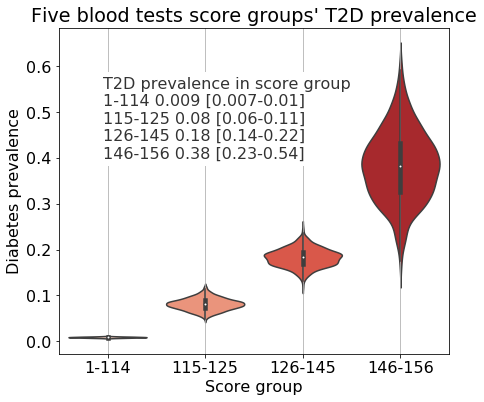

In [24]:
title= "Five blood tests score groups' T2D prevalence"
font = {'family' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)
# Plot the orbital period with horizontal boxes
f, ax = plt.subplots(figsize=(7, 6))
# ax.set_xscale("log")

# sns.violinplot(x="Boundaries", y="Ratio", data=test_rank1K, palette="Greens")
ax = sns.violinplot(x="Boundaries", data=test_rank1K, y="Ratio",palette="Reds",scale="width")
# Add in points to show each observation
# sns.stripplot(x="Boundaries", y="Ratio", data=test_rank1K,
#               size=4, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="Diabetes prevalence",xlabel="Score group")
# sns.despine(trim=True, left=True)
# ax.legend(new_stats_df.Legend,title="T2D prevalence in score group")
text_list="\n".join(list(new_stats_df.Legend.values))
text_list="T2D prevalence in score group\n"+text_list
ax.text(-0.05, 0.4, text_list,fontsize=16,backgroundcolor='white',alpha=0.8)
ax.set_title(title)
plt.savefig(os.path.join(curr_folder,scoreboard_type+"_groups_prevalence.jpeg"))
plt.show()

# Calculate Anthropometrics

In [25]:
curr_folder=os.path.join(base_path, 'LR_Anthro_scoreboard')
scoreboard_type="Anthro"
sb=recover_scoreboard(scoreboard_type)

('Factor:', 14.43, 'Offset:', 43.56)
('Running in ', 'None', ' mode')
('Running in ', 'explore', ' mode')
('Loading ScoreBoard', 'Anthro', ' from ', '/net/mraid08/export/jafar/Yochai/UKBB_Runs/For_article/Imputed_screened/Scoreboards/LR_Anthro_scoreboard')


In [26]:
val_df,val_scores=load_labels(sb,y_file_name="y_LR_val.csv",curr_folder=curr_folder,mode="explore",return_results=True)
test_df,test_scores=load_labels(sb,y_file_name="y_LR_test.csv",curr_folder=curr_folder,mode=None,return_results=True)

In [47]:
n_bins=100
res=1./n_bins
quants_bins=[0.9,0.99,1]
val_Rank_df=pd.DataFrame()
val_Rank_df=calc_Rank_df(val_scores, quants_bins=quants_bins, prevalence_thresh_fold=None,pred_col="y_pred")
val_Rank_df

,quantile number,Lower Boundary,upper Boundary,Diagnosed,All,Ratio,Fold
0,1,0.0,70.0,145.0,9701.0,0.014947,1.000000
1,2,70.0,83.0,79.0,956.0,0.082636,5.528632
2,3,83.0,92.0,15.0,100.0,0.150000,10.035517


In [48]:
boundaries=[0]
boundaries.extend(val_Rank_df.loc[:,["upper Boundary"]].values.flatten().tolist())
val_rank_list=[]
for ind in np.arange(1000):
    sampled_val_scores=val_scores.sample(n=val_scores.shape[0],replace=True)
    val_rank_list.append(test_rank_df(sampled_val_scores, boundaries=boundaries,pred_col="y_pred"))
val_rank1K=pd.concat(val_rank_list)
val_rank1K["Boundaries"]=(val_rank1K["Lower Boundary"]+1).astype(int).astype(str)+"-"+val_rank1K["upper Boundary"].astype(int).astype(str)
val_rank1K.to_csv(os.path.join(curr_folder,base_path,"val_scoreborad_groups_bootstrapping_results.csv"))
new_stats_df=calc_ci(val_rank1K)
new_stats_df.set_index("Boundaries",inplace=True,drop=True)
new_stats_df.sort_values(by="mean",inplace=True,ascending=True)
new_stats_df.to_csv(os.path.join(curr_folder,base_path,"val_scoreborad_groups_results.csv"))
new_stats_df

,mean,0.0275,0.975,CI,Legend
Boundaries,,,,,
1-70,0.01,0.01,0.02,0.01 [0.01-0.02],1-70 0.01 [0.01-0.02]
71-83,0.08,0.07,0.10,0.08 [0.07-0.10],71-83 0.08 [0.07-0.10]
84-92,0.15,0.09,0.23,0.15 [0.09-0.23],84-92 0.15 [0.09-0.23]


In [49]:
test_rank_list=[]
for ind in np.arange(1000):
    sampled_test_scores=test_scores.sample(n=test_scores.shape[0],replace=True)
    test_rank_list.append(test_rank_df(sampled_test_scores, boundaries=boundaries,pred_col="y_pred"))

In [50]:
test_rank1K=pd.concat(test_rank_list)
test_rank1K["Boundaries"]=(test_rank1K["Lower Boundary"]+1).astype(int).astype(str)+"-"+test_rank1K["upper Boundary"].astype(int).astype(str)
test_rank1K.to_csv(os.path.join(curr_folder,base_path,"scoreborad_groups_bootstrapping_results.csv"))
new_stats_df=calc_ci(test_rank1K)
new_stats_df.set_index("Boundaries",inplace=True,drop=True)
new_stats_df.sort_values(by="mean",inplace=True,ascending=True)
new_stats_df.to_csv(os.path.join(curr_folder,base_path,"scoreborad_groups_results.csv"))

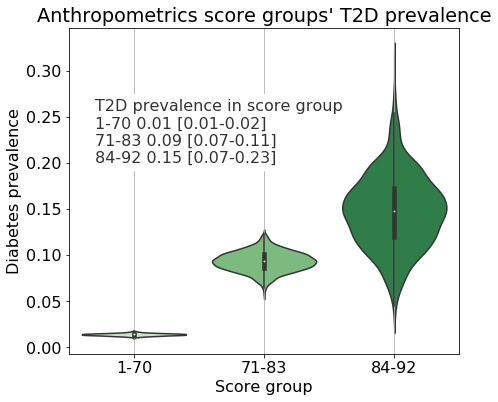

In [51]:
title= "Anthropometrics score groups' T2D prevalence"
font = {'family' : 'normal',
        'size'   : 16}
mpl.rc('font', **font)
# Plot the orbital period with horizontal boxes
f, ax = plt.subplots(figsize=(7, 6))
# ax.set_xscale("log")

# sns.violinplot(x="Boundaries", y="Ratio", data=test_rank1K, palette="Greens")
ax = sns.violinplot(x="Boundaries", data=test_rank1K, y="Ratio",palette="Greens",scale="width")
# Add in points to show each observation
# sns.stripplot(x="Boundaries", y="Ratio", data=test_rank1K,
#               size=4, color=".3", linewidth=0)

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="Diabetes prevalence",xlabel="Score group")
# sns.despine(trim=True, left=True)
# ax.legend(new_stats_df.Legend,title="T2D prevalence in score group")
text_list="\n".join(list(new_stats_df.Legend.values))
text_list="T2D prevalence in score group\n"+text_list
ax.text(-0.3, 0.2, text_list,fontsize=16,backgroundcolor='white',alpha=0.8)
ax.set_title(title)
plt.savefig(os.path.join(curr_folder,scoreboard_type+"_groups_prevalence.jpeg"))
plt.show()